In [1]:
!pip install transformers
!pip install datasets
!pip install torchdata

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig, AutoModelForCausalLM, DataCollatorForTokenClassification, TrainingArguments, Trainer, GenerationConfig
import torch
from torchdata.datapipes.iter import IterableWrapper
import random

from torch.utils.data import Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import json
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

random_state = 33
random.seed(random_state)
torch.random.manual_seed(random_state)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
with open('/kaggle/input/arithmetic/_n_20_m_20_examples_20000000.txt') as f:
    lines = f.readlines()
lines = [i[:-1] for i in lines]
random.shuffle(lines)

In [4]:
def get_op(x):
  sp = x.split('+')
  return [sp[0]] + sp[1].split('=')

test_data, train_data = [], []
counter = [[0] * 21 for i in range(21)]

max_len = 15

max_for_test = 25
for i in lines:
  op = get_op(i)
  len_op = [len(op[0]), len(op[1])]
  if counter[len_op[0]][len_op[1]] < max_for_test:
    counter[len_op[0]][len_op[1]] += 1
    test_data.append(i)
    continue
  if len_op[0] > max_len or len_op[1] > max_len:
    continue
  train_data.append(i)


random.shuffle(test_data)
random.shuffle(train_data)
del lines

In [5]:
model_name = "numind/NuExtract-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model_config = AutoConfig.from_pretrained(model_name)

model_config.bos_token_id = tokenizer.bos_token_id = 151644
model_config.eos_token_id = tokenizer.eos_token_id
model_config.pad_token_id = tokenizer.pad_token_id
assert model_config.eos_token_id == tokenizer.eos_token_id
assert model_config.bos_token_id == tokenizer.bos_token_id
assert model_config.pad_token_id == tokenizer.pad_token_id
print(tokenizer.bos_token, tokenizer.eos_token, tokenizer.pad_token)
tokenizer.padding_side = "left"

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/108 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

<|im_start|> <|end-output|> <|endoftext|>


In [6]:
class ArithmeticDataset(Dataset):
    def __init__(
        self,
        original_records: list,
        tokenizer: AutoTokenizer,
        add_global_bos: bool = True,
        add_global_eos: bool = True,
        labels_pad_token_id: int = -100,
        truncation_side: str = "left",
        train: bool = True
    ):
        self.original_records = original_records
        self.tokenizer = tokenizer
        self.labels_pad_token_id = labels_pad_token_id
        self.add_global_bos = add_global_bos
        self.add_global_eos = add_global_eos
        self.truncation_side = truncation_side
        self.is_printed = False
        self.train = train


        self.records = []
        for record in tqdm(original_records):
            tensors = self.convert_record(record)
            if tensors is None:
                continue
            self.records.append(tensors)

    def __len__(self):
        return len(self.records)

    def __getitem__(self, index):
        return self.records[index]

    def get_tokens(self, text):
        return self.tokenizer.convert_tokens_to_ids([i for i in text])

    def convert_record(self, record):

        input_ids, labels = [], []
        input_ids = self.get_tokens(record)
        labels = input_ids.copy()
        
        idx = labels.index(self.tokenizer.convert_tokens_to_ids(["="])[0])
        labels[:idx + 1] = [self.labels_pad_token_id] * (idx + 1)

        if not input_ids:
            return None

        if self.add_global_bos and input_ids[0] != self.tokenizer.bos_token_id:
            input_ids.insert(0, self.tokenizer.bos_token_id)
            labels.insert(0, self.labels_pad_token_id)

        if self.add_global_eos and input_ids[-1] != self.tokenizer.eos_token_id:
            input_ids.append(self.tokenizer.eos_token_id)
            labels.append(self.tokenizer.eos_token_id)
        
        if not self.train:
            idx = input_ids.index(self.tokenizer.convert_tokens_to_ids(["="])[0])
            labels = input_ids[idx + 1:]
            input_ids = input_ids[:idx + 1]
        if not self.is_printed:
            print(input_ids)
            print(labels)
            self.is_printed = True

        input_ids = torch.LongTensor(input_ids)
        labels = torch.LongTensor(labels)
        attention_mask = input_ids.new_ones(input_ids.size())
        if self.train:
            assert input_ids.size(0) == labels.size(0) == attention_mask.size(0)
        return {
            "input_ids": input_ids,
            "labels": labels,
            "attention_mask": attention_mask
        }

train_dataset = ArithmeticDataset(
    train_data[:int(5e6)],
    tokenizer
)

test_dataset = ArithmeticDataset(
    test_data,
    tokenizer,
    train=False
)

  0%|          | 0/5000000 [00:00<?, ?it/s]

[151644, 18, 17, 23, 16, 17, 17, 24, 20, 15, 20, 10, 20, 17, 23, 18, 22, 18, 19, 15, 24, 17, 23, 20, 28, 23, 19, 21, 20, 24, 20, 18, 21, 24, 22, 23, 20, 151646]
[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 23, 19, 21, 20, 24, 20, 18, 21, 24, 22, 23, 20, 151646]


 23%|██▎       | 2310/10000 [00:00<00:00, 11548.79it/s]

[151644, 19, 17, 16, 10, 23, 23, 24, 16, 21, 24, 17, 16, 21, 18, 17, 18, 17, 15, 19, 18, 18, 21, 23, 17, 28]
[17, 16, 16, 17, 21, 24, 17, 16, 21, 18, 17, 18, 17, 15, 19, 18, 18, 21, 23, 17, 151646]


100%|██████████| 10000/10000 [00:00<00:00, 11529.47it/s]


In [7]:
data_collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=8)

In [8]:
model = AutoModelForCausalLM.from_config(model_config)
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1024, padding_idx=151643)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (down_proj): Linear(in_features=2816, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
 

In [10]:
class Abacus(torch.nn.Module):
    def __init__(self, digit_tokens, embedding_dim, embedding_layer, max_seq_length=1024, max_k=99):
        super().__init__()
        self.embedding_layer = embedding_layer
        self.embedding = torch.nn.Embedding(max_seq_length, embedding_dim)
        self.register_buffer("digits", torch.tensor(digit_tokens), persistent=False)

        self.max_k = max_k

    def helper(self, mask, device):
        mask_shape = mask.shape
        
        shifted_mask = torch.cat([torch.zeros((mask_shape[0], 1), device=device, dtype=mask.dtype), mask[:, :-1]], dim=1)
        starts = (shifted_mask != mask) & mask

        segment_ids = torch.cumsum(starts, dim=1)

        index = torch.arange(mask.size(1)).repeat(mask.size(0), 1).to(device)

        reset_index = torch.zeros_like(mask).long()
        second_term = index * starts.long()
        reset_index = reset_index.scatter_add(1, segment_ids, second_term)

        positions = index - reset_index.gather(1, segment_ids) + 1

        result = positions * mask

        return result

    def forward(self, input_ids):
        mask = torch.isin(input_ids, self.digits)
        output = self.helper(mask, input_ids.device)

        k=0
        if self.training:
            k = random.randint(0, self.max_k)
            output[output>0] += k
        return self.embedding_layer(input_ids) + self.embedding(output)


new_embed_layer = Abacus(tokenizer.convert_tokens_to_ids(['0','1','2','3','4','5','6','7','8','9']), 1024, model.model.embed_tokens, max_seq_length=30, max_k = 10)
model.model.embed_tokens = new_embed_layer
model.to(device)
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Abacus(
      (embedding_layer): Embedding(151936, 1024, padding_idx=151643)
      (embedding): Embedding(30, 1024)
    )
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (down_proj): Linear(in_features=2816, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_a

In [10]:
!mkdir /kaggle/working/train_dir

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [11]:
training_args = TrainingArguments(
  output_dir = '/kaggle/working/train_dir',
  evaluation_strategy = 'no',
  learning_rate=1e-4,
  weight_decay=0.0001,
  num_train_epochs=1,
#   max_steps=12000,
  lr_scheduler_type='cosine',
  save_steps=1000,
  save_total_limit=1,
  seed=random_state,
  report_to='none',
  auto_find_batch_size = True,
  use_cpu = False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
trainer.train()

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Step,Training Loss
500,2.467100
1000,2.184600
1500,2.120400
2000,2.036300
2500,1.975800
3000,1.935200
3500,1.852500
4000,1.773300
4500,1.695600
5000,1.660700


KeyboardInterrupt: 

In [9]:
from safetensors.torch import load_model, save_model

load_model(model, "/kaggle/working/train_dir/checkpoint-42000/model.safetensors")
model.eval()
model.to(device)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1024, padding_idx=151643)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (down_proj): Linear(in_features=2816, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
 

In [11]:
dp = IterableWrapper(test_dataset)
dp = dp.batch(batch_size=4, wrapper_class=data_collator)

generation_config = {
  "_from_model_config": True,
  "bos_token_id": tokenizer.bos_token_id,
  "eos_token_id": tokenizer.eos_token_id,
  "pad_token_id": tokenizer.pad_token_id,
  "transformers_version": "4.42.4",
  "max_new_tokens": 25,
  "use_cache": True
}

with open('/kaggle/working/generation_config.json', 'w') as fp:
    json.dump(generation_config, fp)

generation_config = GenerationConfig.from_pretrained(pretrained_model_name=model_name, config_file_name='/kaggle/working/generation_config.json')
generation_config

GenerationConfig {
  "bos_token_id": 151644,
  "eos_token_id": 151646,
  "max_new_tokens": 25,
  "pad_token_id": 151643
}

In [12]:
def convert_to_list(x):
    x = x.cpu().tolist()
    res = []
    for i in x:
        l = 0
        while i[l] in [tokenizer.pad_token_id, tokenizer.bos_token_id, -100]:
            l += 1
        r = len(i) - 1
        while i[r] == tokenizer.pad_token_id and r > l:
            r -= 1
        res.append(i[l:r + 1])
    return res

global_res = [[0] * 21 for i in range(21)]
def compute_metric(x, labels):
    global global_res
    assert len(x) == len(labels)
    x, labels = convert_to_list(x), convert_to_list(labels)
    x_label, op1, op2 = [], [], []
    for i in x:
        idx1 = i.index(tokenizer.convert_tokens_to_ids(["+"])[0])
        idx2 = i.index(tokenizer.convert_tokens_to_ids(["="])[0])
        op1.append(i[:idx1])
        op2.append(i[idx1 + 1: idx2])
        x_label.append(i[idx2 + 1:])
    res = 0
    for en, (i, j) in enumerate(zip(x_label, labels)):
        if len(i) != len(j):
            continue
        for k in range(len(i)):
            if i[k] != j[k]:
                break
            if k == len(i) - 1:
                global_res[len(op1[en])][len(op2[en])] += 1
                res += 1
    return res

In [13]:
res = 0
for batch in tqdm(dp):
    with torch.no_grad():
        output = model.generate(input_ids=batch["input_ids"].to(device),generation_config=generation_config)
        a = compute_metric(output, batch["labels"])
        res += a

100%|██████████| 2500/2500 [19:59<00:00,  2.08it/s]


In [51]:
print("Overall accuracy =", res / 1e4)

Overall accuracy = 0.5055


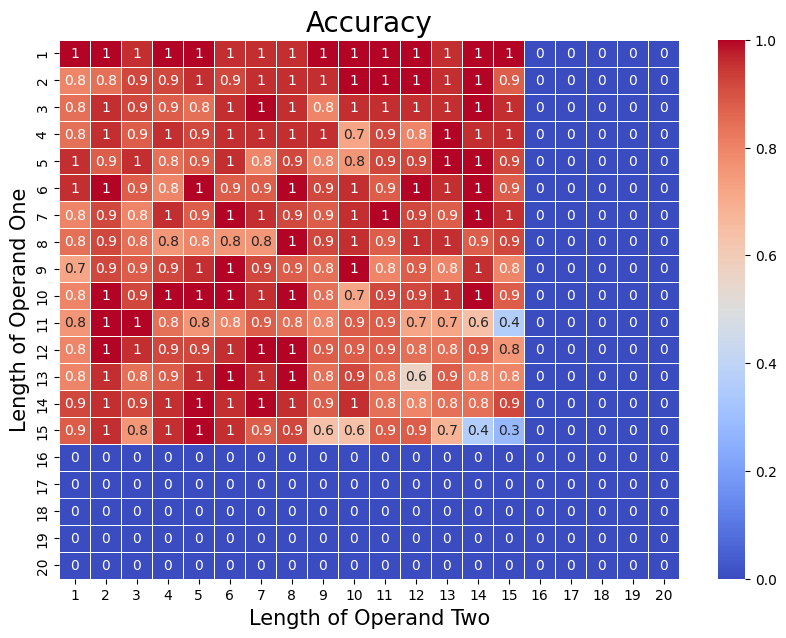

In [49]:
global_res = [[j / 25 for j in i[1:]] for i in global_res]
del global_res[0]
df = pd.DataFrame(global_res, columns=[i for i in range(1, 21)])
df.index = np.arange(1, len(df) + 1)
fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(df, linewidth=0.5, cmap='coolwarm', annot=True, fmt='.1g')
plt.title('Accuracy', fontsize = 20)
plt.xlabel('Length of Operand Two', fontsize = 15)
plt.ylabel('Length of Operand One', fontsize = 15)

plt.show()